In [1]:
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import MinMaxScaler # Data normalization
from xgboost import XGBRegressor, DMatrix, plot_importance # XGBoost

In [3]:
# pip install tensorflow==2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ipcvlab/anaconda2/e

In [4]:
df_train = pd.read_excel("/home/ipcvlab/Downloads/ilceler/yıllık-ilk-calısma/umraniye_tum_veriler.xlsx", index_col = 0) 
cols_list = list(df_train.columns) 

In [5]:
df_train.head()

,HouseEndex,bist,USD/TRY,Aylık_Mevduat_Faizi,Konut_Kredisi,ic_borc_maliyet,tufe_endeks,guven_endeksi,kira endex
Tarih,,,,,,,,,
2007-06,100.0,47093.67,1.321548,17.588,18.0320,18.420723,139.69,80.949646,100.0
2007-07,100.8,52824.89,1.282132,17.520,17.4275,17.401225,138.67,82.270595,101.1
2007-08,102.9,50198.60,1.314595,17.452,17.1200,19.052940,138.70,85.024409,103.8
2007-09,106.6,54044.22,1.267385,17.335,17.5825,18.250570,140.13,83.885017,107.8
2007-10,108.6,57615.72,1.202367,16.905,17.2675,16.323523,142.67,82.975294,110.5


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 2007-06 to 2019-12
Data columns (total 9 columns):
HouseEndex              151 non-null float64
bist                    151 non-null float64
USD/TRY                 151 non-null float64
Aylık_Mevduat_Faizi     151 non-null float64
Konut_Kredisi           151 non-null float64
ic_borc_maliyet         151 non-null float64
tufe_endeks             151 non-null float64
guven_endeksi           151 non-null float64
kira endex              151 non-null float64
dtypes: float64(9)
memory usage: 11.8+ KB


In [7]:
df_train.describe()

,HouseEndex,bist,USD/TRY,Aylık_Mevduat_Faizi,Konut_Kredisi,ic_borc_maliyet,tufe_endeks,guven_endeksi,kira endex
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,186.823179,71935.466291,2.589480,10.870206,13.967113,12.049846,244.453444,70.423582,163.014570
std,81.971852,22202.415236,1.381563,4.363666,3.984043,4.551850,80.716599,7.192777,59.133684
min,84.100000,24026.590000,1.176086,5.264000,8.297500,5.685006,138.670000,55.136536,83.900000
25%,113.500000,55799.800000,1.560281,7.537500,11.297500,8.949530,178.360000,65.648253,112.850000
50%,151.000000,73995.200000,1.993883,9.265000,12.868000,10.428706,223.910000,71.309231,135.200000
75%,279.050000,86107.350000,3.173407,12.277500,16.129000,14.648636,287.070000,75.903437,239.600000
max,310.500000,119528.790000,6.378340,22.852500,28.947500,25.808845,440.500000,85.024409,254.500000


### display Missing values

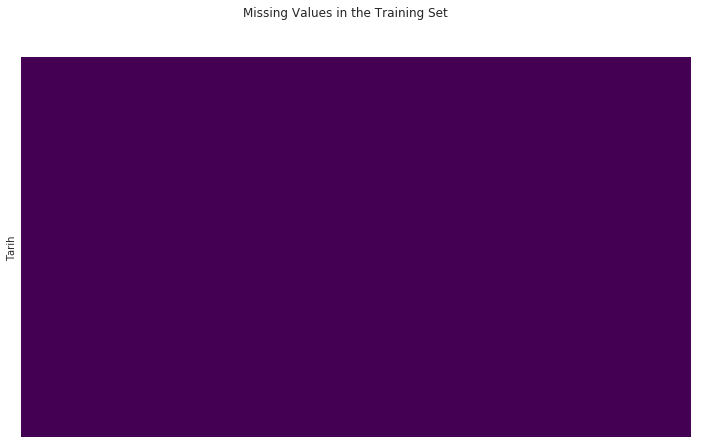

In [8]:
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [9]:
replace = True # True: replace null in guven_endeksi with average. False: guven_endeksi kullanmadan
if replace:
    df_train = df_train.fillna(df_train.mean())
else:
    df_train.drop('guven_endeksi', axis=1, inplace=True)

In [10]:
# Correlation matrix
corr_mat = df_train.corr().abs()
# Find most important features relative to target
corr_mat.sort_values(by=["HouseEndex"], ascending = False, inplace = True)
print(corr_mat.HouseEndex)

HouseEndex              1.000000
kira endex              0.995120
tufe_endeks             0.935672
USD/TRY                 0.900205
bist                    0.875345
guven_endeksi           0.444783
Aylık_Mevduat_Faizi     0.275608
ic_borc_maliyet         0.235339
Konut_Kredisi           0.168683
Name: HouseEndex, dtype: float64


In [11]:
#Correlation matrix between features
corr_mat = df_train.corr().abs()

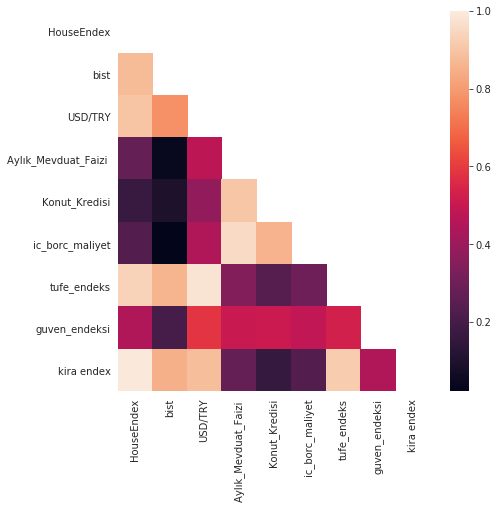

In [12]:
#Plot the heatmap with seaborn
plt.figure(figsize=(7,7)) 

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_mat, mask=mask,
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [13]:
#List the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-10:-len(corr_mat)])

tufe_endeks           kira endex              0.918835
kira endex            tufe_endeks             0.918835
tufe_endeks           HouseEndex              0.935672
HouseEndex            tufe_endeks             0.935672
ic_borc_maliyet       Aylık_Mevduat_Faizi     0.954900
Aylık_Mevduat_Faizi   ic_borc_maliyet         0.954900
tufe_endeks           USD/TRY                 0.978278
USD/TRY               tufe_endeks             0.978278
kira endex            HouseEndex              0.995120
HouseEndex            kira endex              0.995120
dtype: float64


In [14]:
# Find most important features relative to target
corr_mat.sort_values(["HouseEndex"], ascending = False, inplace = True)
print(corr_mat.HouseEndex)

HouseEndex              1.000000
kira endex              0.995120
tufe_endeks             0.935672
USD/TRY                 0.900205
bist                    0.875345
guven_endeksi           0.444783
Aylık_Mevduat_Faizi     0.275608
ic_borc_maliyet         0.235339
Konut_Kredisi           0.168683
Name: HouseEndex, dtype: float64


# Skewness

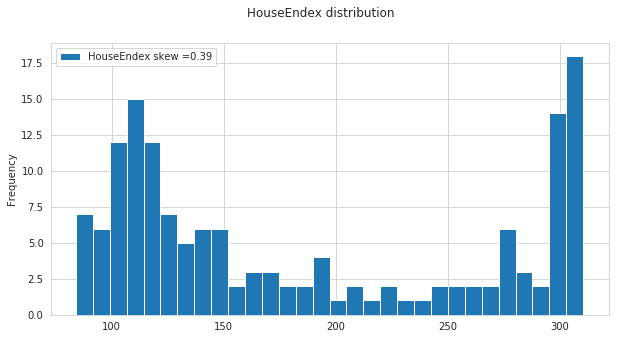

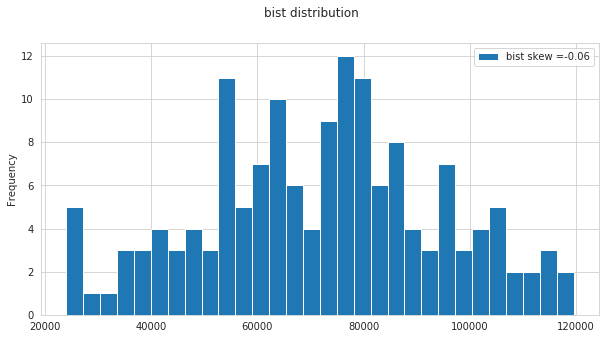

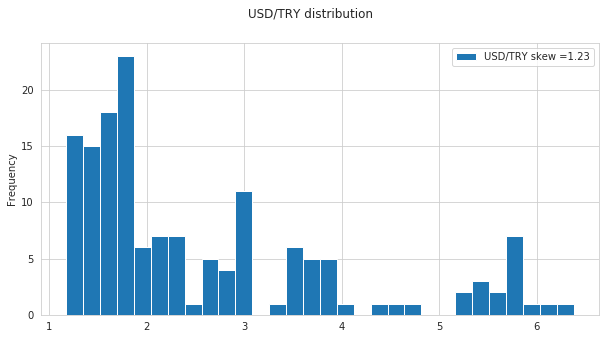

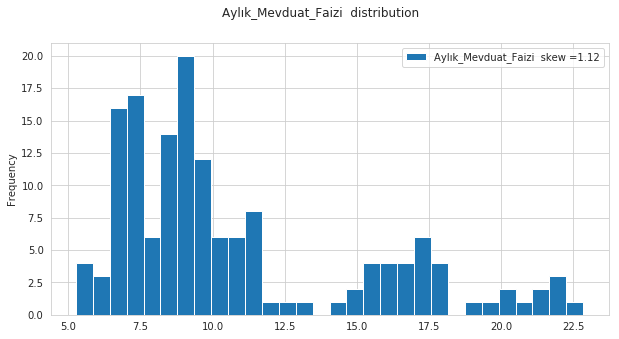

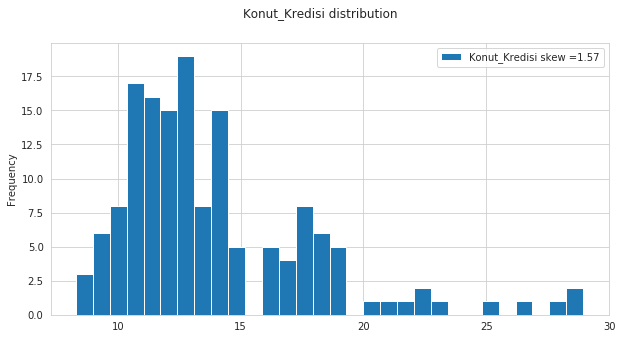

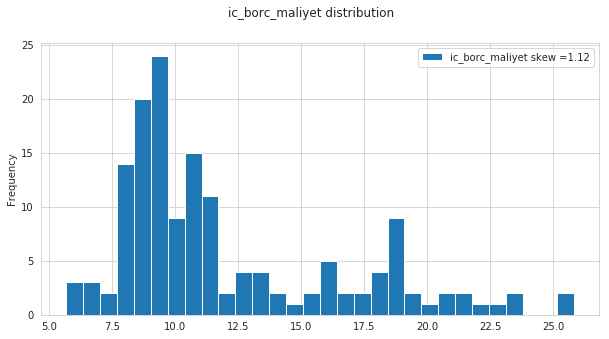

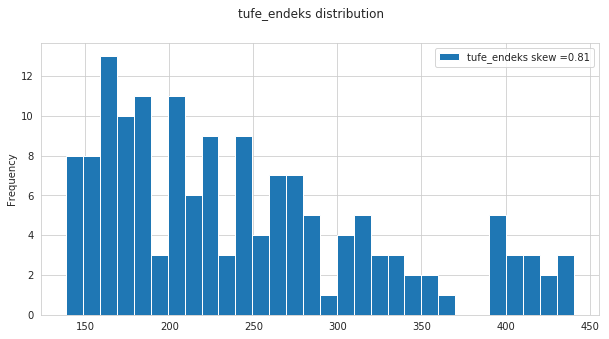

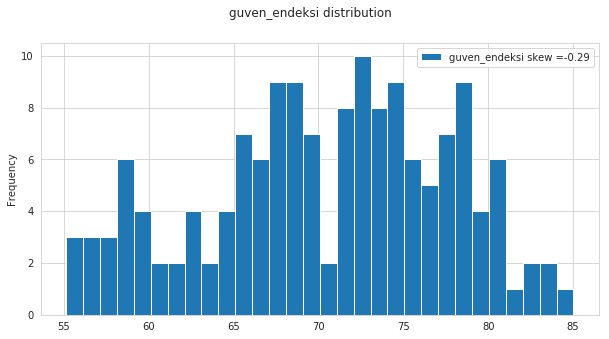

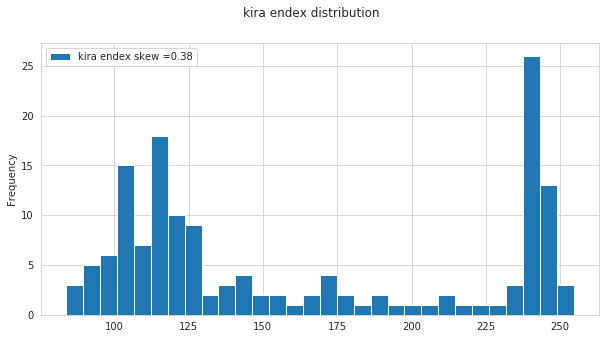

In [15]:
#Check the skewness of HouseEndeks
for col in cols_list:
    plt.figure(figsize=(10, 5))
    skewness = df_train[col].skew()
    df_train[col].plot.hist(edgecolor='white', bins=30, 
                                    label=col + ' skew =' + str(round(skewness,2)))
    plt.suptitle("{} distribution".format(col))
    plt.legend()
    plt.show()

# Box plots

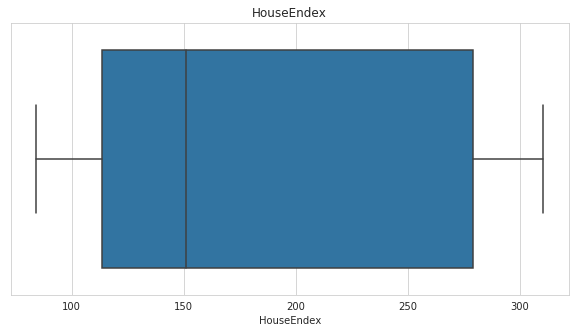

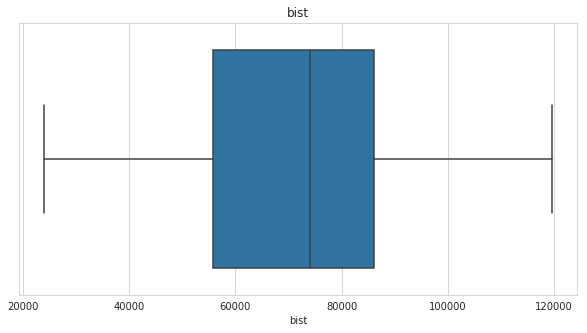

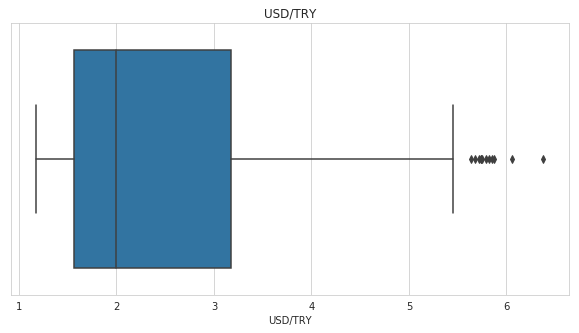

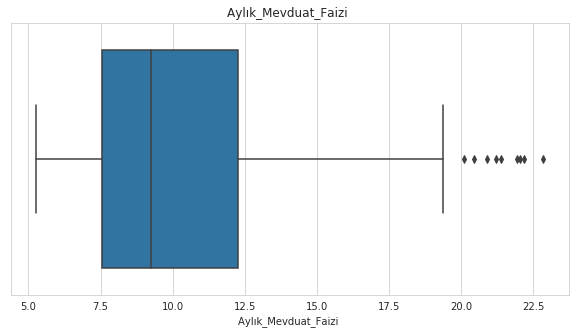

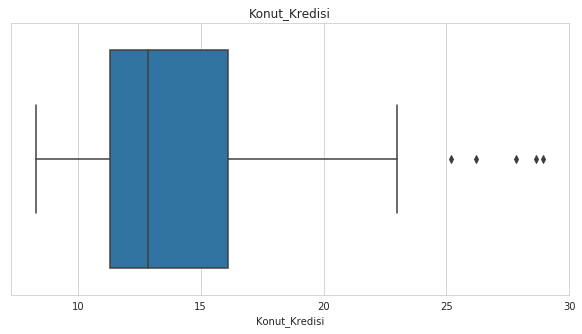

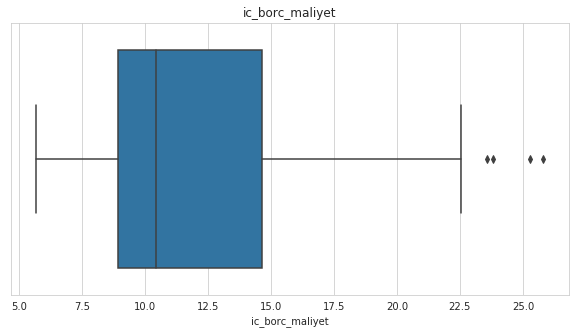

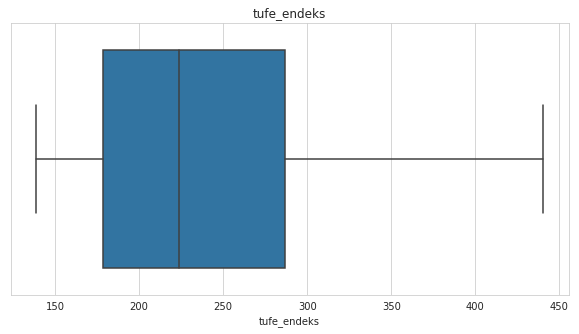

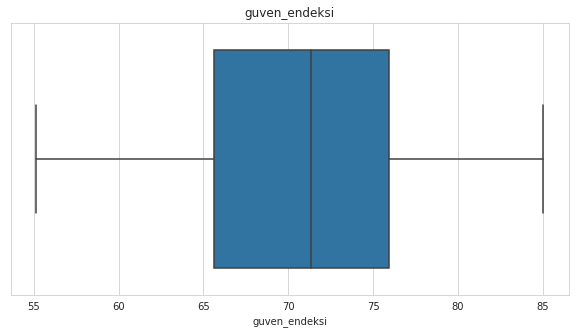

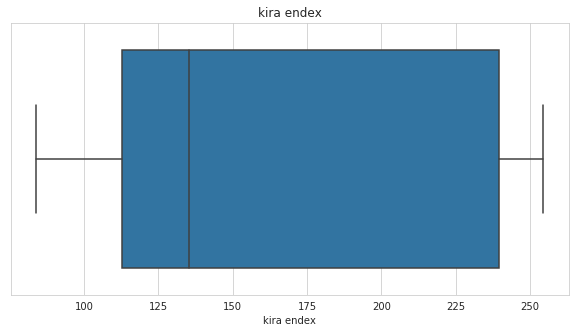

In [16]:
for col in cols_list:
    plt.figure(figsize=(10, 5))
    # Create the boxplot
    ax = sns.boxplot(x=col, data=df_train)
    # Set the `xlim`
    #ax.set(xlim=(0, 100))
    # Add title
    ax.set_title(col)
    # Show the plot
    plt.show()

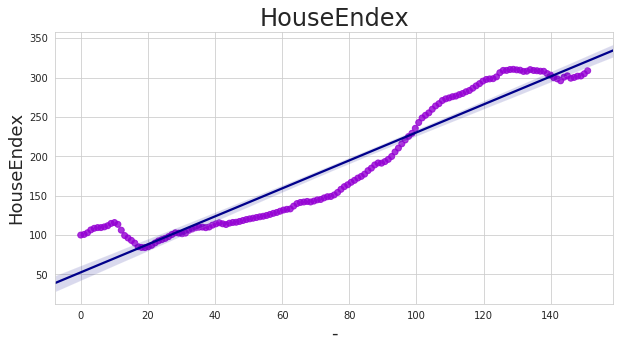

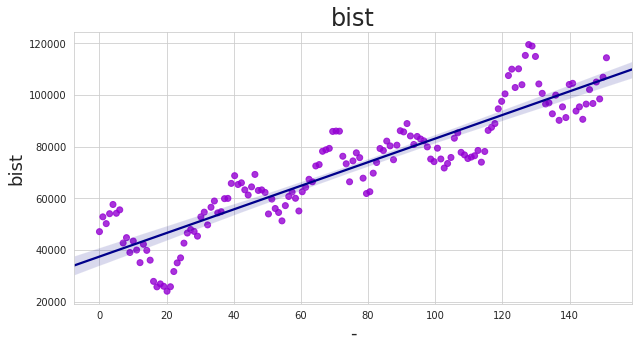

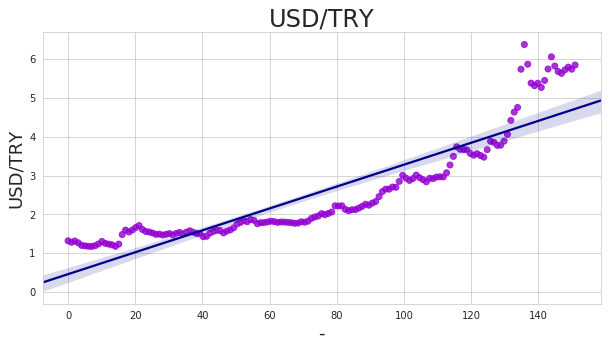

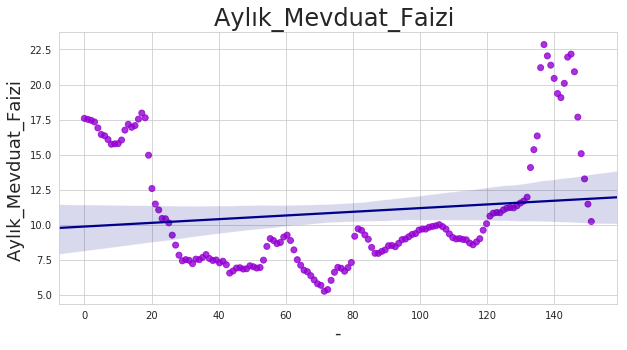

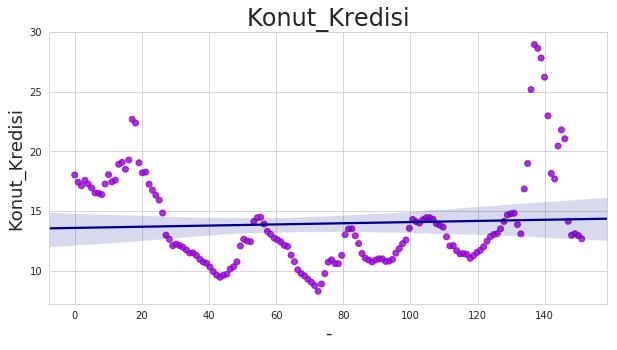

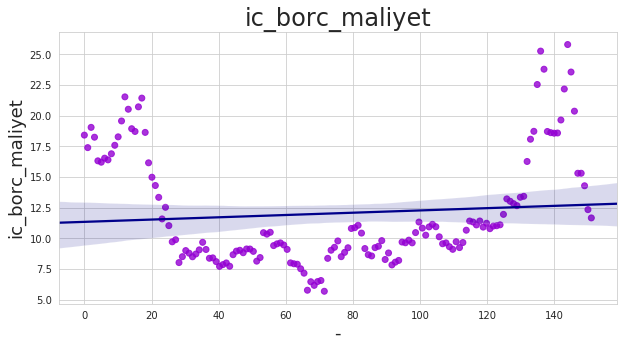

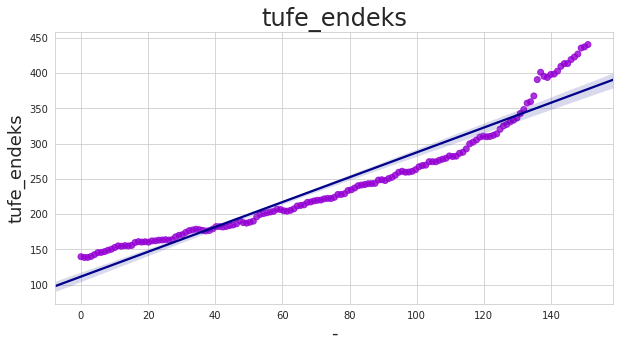

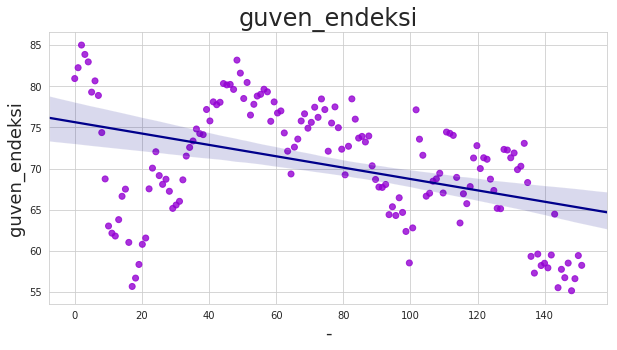

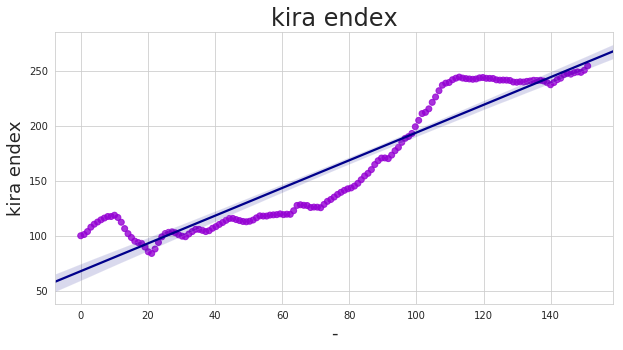

In [17]:
for col in cols_list:    
    y_axis = col
    count = df_train[y_axis].count()
    value=df_train[y_axis]

    plt.figure(figsize=(10, 5))
    sns.regplot(np.linspace(0, count, count), df_train[y_axis], fit_reg=True,
                scatter_kws={'facecolors':np.where( value==True , "red", 'darkviolet'),
               'edgecolor':np.where(value==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkblue'})
    plt.title(col, fontsize=24)
    plt.xlabel('-', fontsize=18)
    plt.ylabel(col, fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')


# HouseEndex vs other

- Kirmizi: bubble fiyatlari iceren regresyon cizgi
- Mavi: bubble fiyatlari iceren regresyon cizgi

mavi ve kirmizi cizgi arasinda buyuk bir fark varsa, bubble/anomaly mi demek?

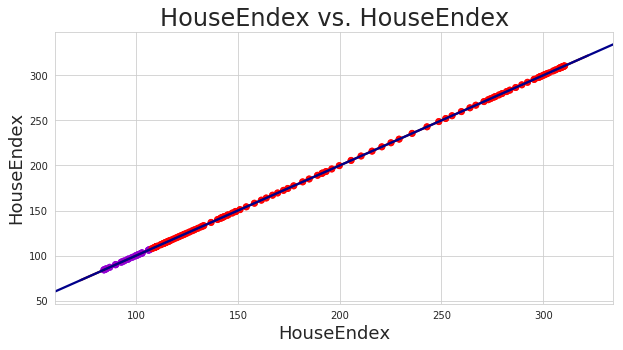

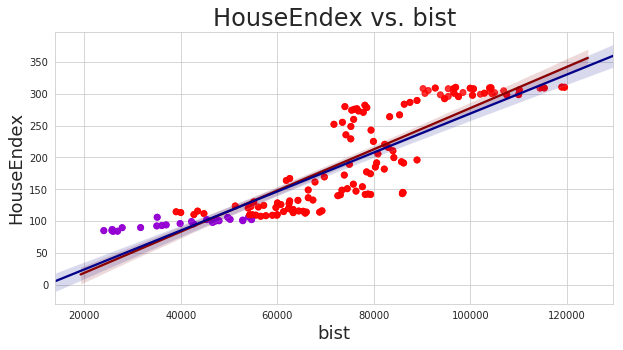

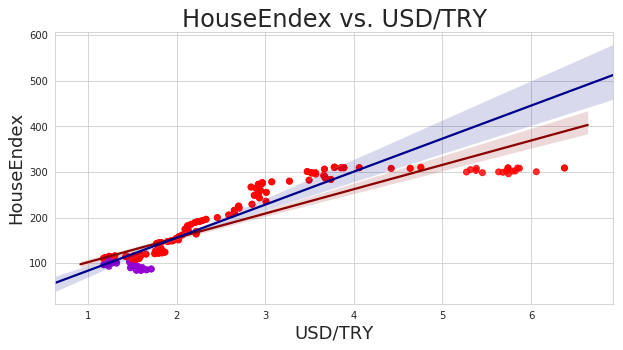

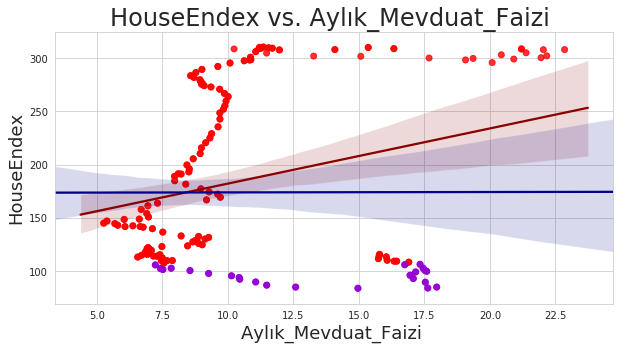

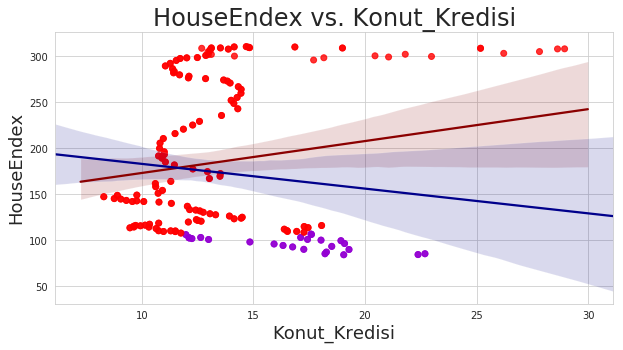

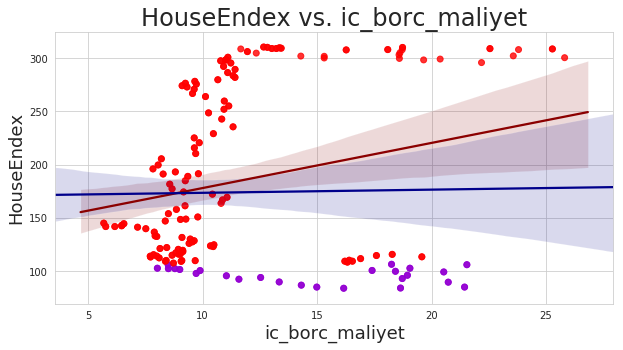

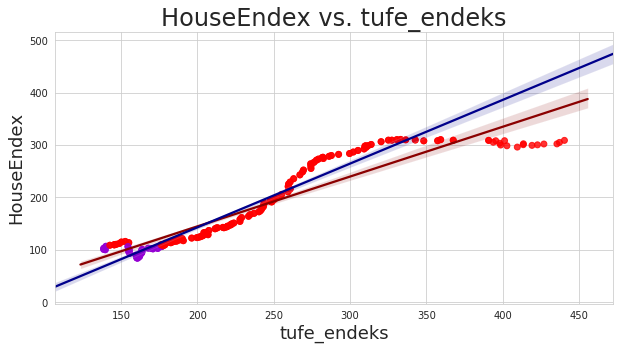

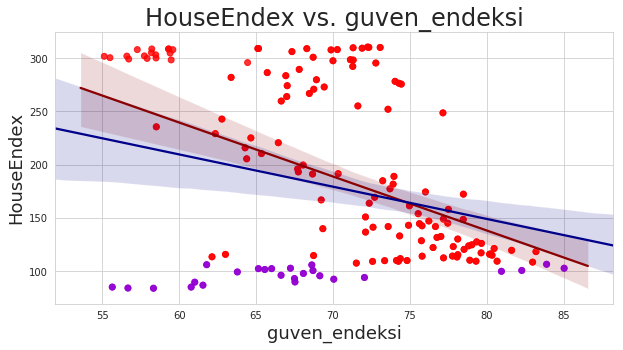

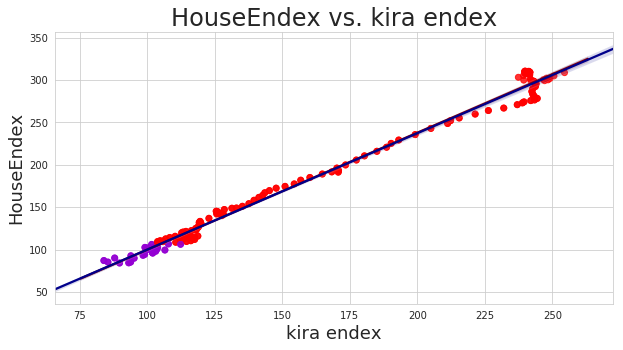

In [18]:
# Displays A Scatter Plot with Regression Line + Outliers in Red

for col in cols_list:
    x_axis = col
    y_axis = 'HouseEndex'
    value=(df_train[y_axis] > 107)
    value2=(df_train[y_axis][:-15] > 107)

    plt.figure(figsize=(10, 5))
    sns.regplot(df_train[x_axis], df_train[y_axis], fit_reg=True,
                scatter_kws={'facecolors':np.where( value==True , "red", 'darkviolet'),
               'edgecolor':np.where(value==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkred'})
    
    sns.regplot(df_train[x_axis][:-15], df_train[y_axis][:-15], fit_reg=True,
                scatter_kws={'facecolors':np.where( value2==True , "red", 'darkviolet'),
               'edgecolor':np.where(value2==True , "red", 'darkviolet')},
               line_kws = {'color': 'darkblue'})
    
    plt.title('HouseEndex vs. {}'.format(x_axis), fontsize=24)
    plt.xlabel(x_axis, fontsize=18)
    plt.ylabel('HouseEndex', fontsize=18)
    # plt.savefig('figures/Standardised_SalePrice_GrLivArea.png')


# XGBoost

hiç faydası yok bu konuda, eğitimde kullandığımız verileri göre sonuç veriyor, ama şişik olup olmadığını gösteremez

In [19]:
#y_full = df_train['HouseEndex']
#X_full = df_train.drop(columns=["HouseEndex"])

y_full = df_train['HouseEndex'][:-15]
X_full = df_train.drop(columns=["HouseEndex"])[:-15]

y_test = df_train['HouseEndex'][-15:]
X_test = df_train.drop(columns=["HouseEndex"])[-15:]

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=123)

In [20]:
# final model with tuned parameters
model = XGBRegressor(max_depth=6, #dflt 6
                     learning_rate=0.1, #dflt 100
                     n_estimators=1000, #dflt 0.1
                     verbosity = 3,
                     objective='reg:linear',
                     n_jobs=-1,
                     gamma=0, #dflt: 0
                     min_child_weight=3, #0 dflt: 1
                     subsample=0.5,
                     colsample_bytree=1,
                     reg_lambda=0.99994, #dflt: 1
                     reg_alpha=0.00003, #dflt: 0
                     tree_method='exact',
                     scale_pos_weight=1, # dflt: 1
                     random_state=123)

In [21]:
tick=time.time()

fitted_model = model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         eval_metric='rmse', # Equivalent to RMSLE since we have log1p(SalePrice)
                         early_stopping_rounds=1000,
                         verbose=True)

print("Duration: {}s".format(time.time()-tick))

[21:40:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[0]	validation_0-rmse:175.861
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	validation_0-rmse:160.666
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[2]	validation_0-rmse:146.444
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/

[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[37]	validation_0-rmse:7.04065
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=5
[38]	validation_0-rmse:6.60472
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[39]	validation_0-rmse:6.30559
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[40]	validation_0-rmse:5.90395
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

/home/ipcvlab/anaconda2/envs/data_science/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[61]	validation_0-rmse:3.52511
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[62]	validation_0-rmse:3.51902
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[63]	validation_0-rmse:3.51126
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[64]	validation_0-rmse:3.50819
[21:40:14] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[99]	validation_0-rmse:3.36926
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[100]	validation_0-rmse:3.37477
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[101]	validation_0-rmse:3.35641
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[102]	validation_0-rmse:3.35601
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[137]	validation_0-rmse:3.32034
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[138]	validation_0-rmse:3.32572
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[139]	validation_0-rmse:3.32235
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[140]	validation_0-rmse:3.31457
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[175]	validation_0-rmse:3.31556
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[176]	validation_0-rmse:3.31703
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[177]	validation_0-rmse:3.31998
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[178]	validation_0-rmse:3.32235
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[213]	validation_0-rmse:3.30551
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[214]	validation_0-rmse:3.30696
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[215]	validation_0-rmse:3.30751
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[216]	validation_0-rmse:3.30802
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[251]	validation_0-rmse:3.29713
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[252]	validation_0-rmse:3.29868
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[253]	validation_0-rmse:3.29804
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[254]	validation_0-rmse:3.29664
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[288]	validation_0-rmse:3.2929
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[289]	validation_0-rmse:3.29169
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[290]	validation_0-rmse:3.29049
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[291]	validation_0-rmse:3.2908
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree 

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[326]	validation_0-rmse:3.28187
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[327]	validation_0-rmse:3.28135
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[328]	validation_0-rmse:3.28145
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[329]	validation_0-rmse:3.28129
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[363]	validation_0-rmse:3.28291
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[364]	validation_0-rmse:3.28178
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=6
[365]	validation_0-rmse:3.28186
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[366]	validation_0-rmse:3.28159
[21:40:15] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[401]	validation_0-rmse:3.27984
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[402]	validation_0-rmse:3.28011
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[403]	validation_0-rmse:3.2801
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[404]	validation_0-rmse:3.28037
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[439]	validation_0-rmse:3.27901
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[440]	validation_0-rmse:3.27878
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[441]	validation_0-rmse:3.27869
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[442]	validation_0-rmse:3.27863
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[477]	validation_0-rmse:3.27769
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[478]	validation_0-rmse:3.27778
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[479]	validation_0-rmse:3.27773
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[480]	validation_0-rmse:3.27775
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[515]	validation_0-rmse:3.27659
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[516]	validation_0-rmse:3.27664
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[517]	validation_0-rmse:3.27679
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[518]	validation_0-rmse:3.27679
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[553]	validation_0-rmse:3.2766
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[554]	validation_0-rmse:3.27655
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[555]	validation_0-rmse:3.27648
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[556]	validation_0-rmse:3.27648
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[591]	validation_0-rmse:3.27636
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[592]	validation_0-rmse:3.27637
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[593]	validation_0-rmse:3.27638
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[594]	validation_0-rmse:3.27633
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[628]	validation_0-rmse:3.27612
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[629]	validation_0-rmse:3.2761
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[630]	validation_0-rmse:3.27602
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[631]	validation_0-rmse:3.27602
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=6
[632]	validation_0-rmse:3.27607
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/sr

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[667]	validation_0-rmse:3.27596
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=6
[668]	validation_0-rmse:3.27596
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[669]	validation_0-rmse:3.27599
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[670]	validation_0-rmse:3.27602
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[705]	validation_0-rmse:3.27586
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[706]	validation_0-rmse:3.27584
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[707]	validation_0-rmse:3.27583
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=6
[708]	validation_0-rmse:3.2758
[21:40:16] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[743]	validation_0-rmse:3.27565
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[744]	validation_0-rmse:3.27564
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[745]	validation_0-rmse:3.27564
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[746]	validation_0-rmse:3.27564
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree

[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=4
[781]	validation_0-rmse:3.27555
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=6
[782]	validation_0-rmse:3.27556
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[783]	validation_0-rmse:3.27556
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[784]	validation_0-rmse:3.27556
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tre

[818]	validation_0-rmse:3.27548
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[819]	validation_0-rmse:3.27548
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[820]	validation_0-rmse:3.27548
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[821]	validation_0-rmse:3.2755
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[822]	validation_0-rmse:3.2755
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tr

[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[857]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[858]	validation_0-rmse:3.27544
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[859]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[860]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree p

[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[895]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[896]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[897]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[898]	validation_0-rmse:3.27546
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pr

[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[933]	validation_0-rmse:3.27543
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=5
[934]	validation_0-rmse:3.27544
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[935]	validation_0-rmse:3.27543
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[936]	validation_0-rmse:3.27544
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree p

[970]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[971]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[972]	validation_0-rmse:3.27545
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[973]	validation_0-rmse:3.27546
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[974]	validation_0-rmse:3.27546
[21:40:17] INFO: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/t

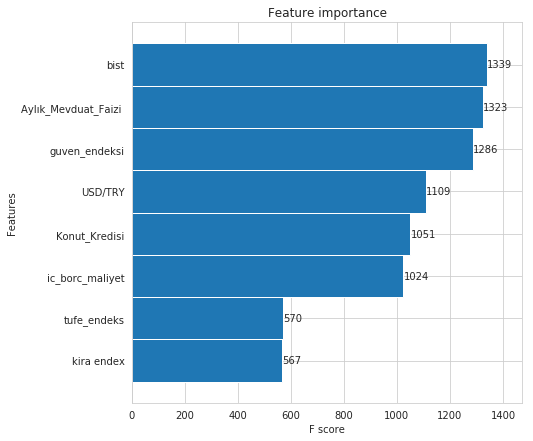

In [22]:
# Plot feature importance
figsize=(7,7)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)


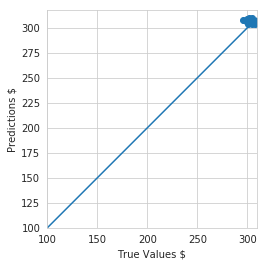

In [23]:
# predict sales in test dataset
test_predictions = model.predict(X_test).flatten()

# scatter plot of True vs Predicted values
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([100,plt.xlim()[1]])
plt.ylim([100,plt.ylim()[1]])
_ = plt.plot([0, 1000], [0, 1000])

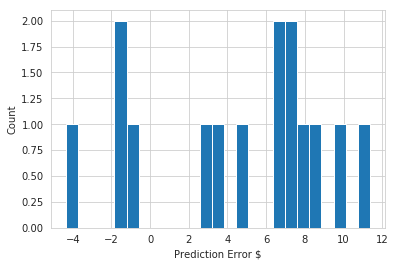

In [24]:
# Histogram of error values
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

# Anomaly detection approach

Loss > Threshold ise = anomaly > bubble mi demek?

In [25]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(df_train[:-15]) # Healthy/normal data
X_test = scaler.fit_transform(df_train[-15:]) # Unhealthy/anomaly data

In [26]:
X_train.shape

(136, 9)

In [27]:
# Reshape for LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [28]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [29]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 9)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 16)             1664      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 4)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 4)              144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 16)             1344      
_________________________________________________________________
time

In [30]:
history = model.fit(X_train, X_train, epochs=100, batch_size=10,
                    validation_split=0.05).history

Train on 129 samples, validate on 7 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
129/129 [==============================] - 5s 40ms/sample - loss: 0.3390 - val_loss: 0.7108
Epoch 2/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.3239 - val_loss: 0.6944
Epoch 3/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.3083 - val_loss: 0.6765
Epoch 4/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.2917 - val_loss: 0.6562
Epoch 5/100
129/129 [==============================] - 0s 3ms/sample - loss: 0.2741 - val_loss: 0.6327
Epoch 6/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.2563 - val_loss: 0.6043
Epoch 7/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.2387 - val_loss: 0.5664
Epoch 8/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.2202 - val_loss: 0.5079
Epoch 9/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.2029

129/129 [==============================] - 0s 2ms/sample - loss: 0.0920 - val_loss: 0.2181
Epoch 77/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.0917 - val_loss: 0.2124
Epoch 78/100
129/129 [==============================] - 0s 2ms/sample - loss: 0.0916 - val_loss: 0.2123
Epoch 79/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.0914 - val_loss: 0.2106
Epoch 80/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.0906 - val_loss: 0.2145
Epoch 81/100
129/129 [==============================] - 0s 848us/sample - loss: 0.0906 - val_loss: 0.1998
Epoch 82/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.0897 - val_loss: 0.2098
Epoch 83/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.0894 - val_loss: 0.2051
Epoch 84/100
129/129 [==============================] - 0s 1ms/sample - loss: 0.0890 - val_loss: 0.2115
Epoch 85/100
129/129 [==============================] - 0s 1ms/sample - los

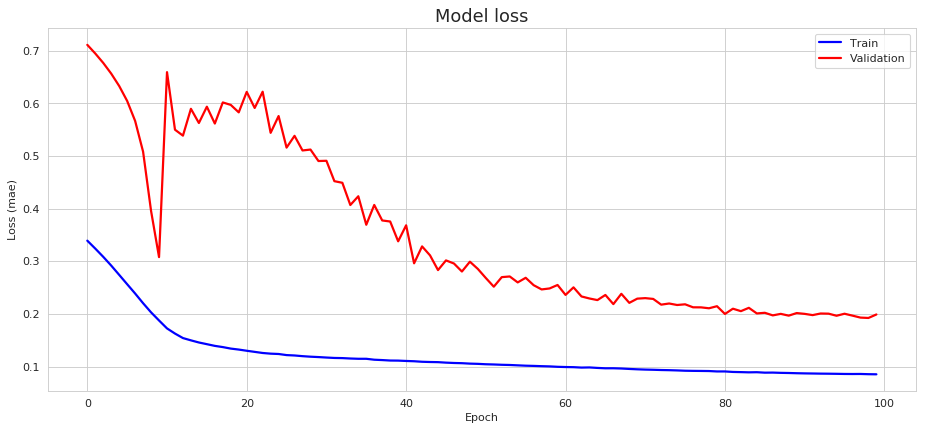

In [31]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

(0.0, 0.5)

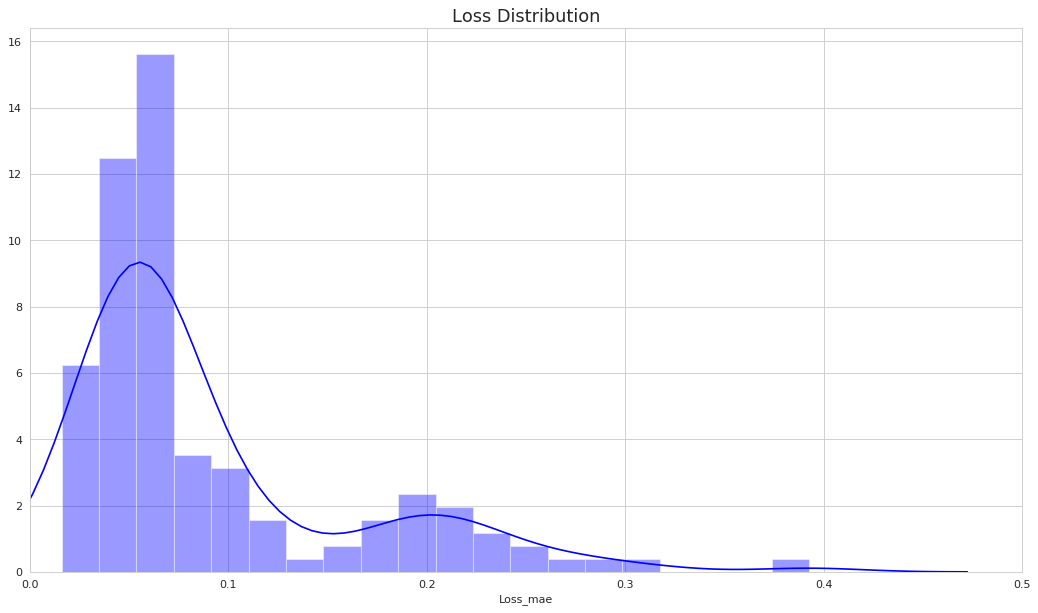

In [32]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[:-15].index

scored = pd.DataFrame(index=df_train[:-15].index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

#Out[17]:
#(0.0, 0.5)

In [33]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=df_train.columns)
X_pred.index = df_train[-15:].index

scored = pd.DataFrame(index=df_train[-15:].index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
Tarih,,,
2018-10,0.509892,0.2,True
2018-11,0.352261,0.2,True
2018-12,0.347805,0.2,True
2019-01,0.303909,0.2,True
2019-02,0.239245,0.2,True


In [34]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=df_train[:-15].columns)
X_pred_train.index = df_train[:-15].index

scored_train = pd.DataFrame(index=df_train[:-15].index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored
scored.to_csv("/home/ipcvlab/Desktop/output.csv")

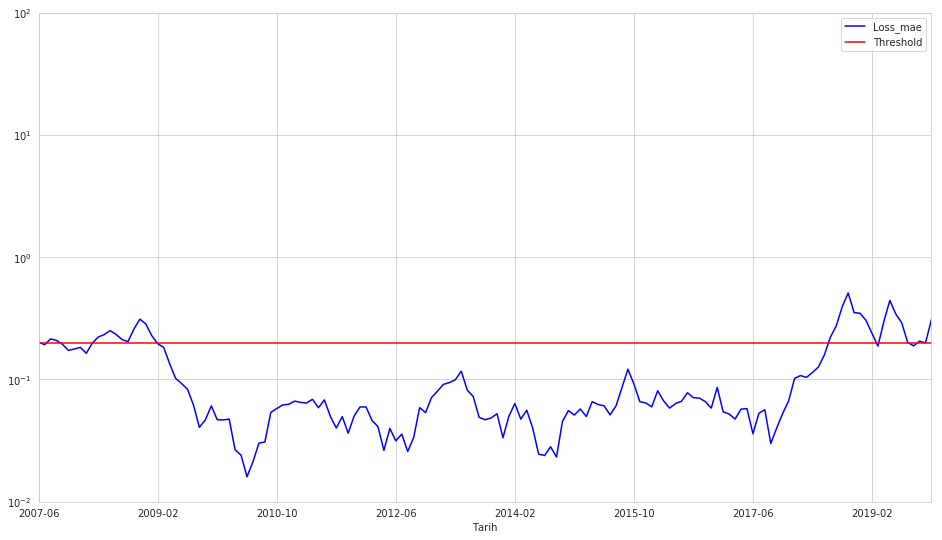

In [35]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])